# Building Advanced Transformers

Transfer architecture key components : 
- input embedding : converts input tokens into vectors
- positional encoding : injects information about the position of input tokens.
- multi-head self attention : allows the model to fouc on different parts of the input sequence.
- feedforward layers : process the attended information.
- layer normalization & residual connections : stabilize and speed up training.

## Import necessary libraries

In [4]:
%pip install tensorflow pyarrow 
%pip install pandas  
%pip install scikit-learn 
%pip install matplotlib 
%pip install requests

  Using cached absl_py-2.3.1-py3-none-any.whl.metadata (3.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.12.19-py2.py3-none-any.whl.metadata (1.0 kB)
  Using cached gast-0.7.0-py3-none-any.whl.metadata (1.5 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached termcolor-3.3.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached tensorboard-2.20.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached rich-14.2.0-py3-none-any.whl.metadata (18 kB)
  Using cached namex-0.1.0-py3-none-any.whl.metadata (322 bytes)
  Using cached markdown-3.10-py3-none-any.whl.metadata (5.1 kB)
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
  Using cached werkzeug-3.1.5-py3-none-any.whl.metadata (4.0 kB)
  Using cached markdown_it_py-4.0.0-py3-none

In [5]:
import numpy as np 
import pandas as pd 
import tensorflow as tf 
import requests
from sklearn.preprocessing import MinMaxScaler 
from tensorflow.keras.layers import Layer, Dense, LayerNormalization, Dropout

## Generate synthetic stock price data

In [6]:
import numpy as np
import pandas as pd

# Create a synthetic stock price dataset
np.random.seed(42)
data_length = 2000  # Adjust data length as needed
trend = np.linspace(100, 200, data_length)
noise = np.random.normal(0, 2, data_length)
synthetic_data = trend + noise

# Create a DataFrame and save as 'stock_prices.csv'
data = pd.DataFrame(synthetic_data, columns=['Close'])
data.to_csv('stock_prices.csv', index=False)
print("Synthetic stock_prices.csv created and loaded.")

Synthetic stock_prices.csv created and loaded.


In [7]:
# Load the dataset 
data = pd.read_csv('stock_prices.csv') 
data = data[['Close']].values 

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

# Prepare the data for training
def create_dataset(data, time_step=1):
    X, Y = [], []

    for i in range(len(data)-time_step-1):
        a = data[i:(i+time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 100
X, Y = create_dataset(data, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)

print("Shape of X:", X.shape) 
print("Shape of Y:", Y.shape) 

Shape of X: (1899, 100, 1)
Shape of Y: (1899,)


## Implement Multi-Head Self Attention

In [8]:
class MultiHeadSelfAttention(Layer): 

    def __init__(self, embed_dim, num_heads=8): 
        super(MultiHeadSelfAttention, self).__init__() 
        self.embed_dim = embed_dim 
        self.num_heads = num_heads 
        self.projection_dim = embed_dim // num_heads 
        self.query_dense = Dense(embed_dim) 
        self.key_dense = Dense(embed_dim) 
        self.value_dense = Dense(embed_dim) 
        self.combine_heads = Dense(embed_dim) 


    def attention(self, query, key, value): 
        score = tf.matmul(query, key, transpose_b=True) 
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32) 
        scaled_score = score / tf.math.sqrt(dim_key) 
        weights = tf.nn.softmax(scaled_score, axis=-1) 
        output = tf.matmul(weights, value) 
        return output, weights 

    def split_heads(self, x, batch_size): 
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim)) 
        return tf.transpose(x, perm=[0, 2, 1, 3]) 

    def call(self, inputs): 
        batch_size = tf.shape(inputs)[0] 
        query = self.query_dense(inputs) 
        key = self.key_dense(inputs) 
        value = self.value_dense(inputs) 
        query = self.split_heads(query, batch_size) 
        key = self.split_heads(key, batch_size) 
        value = self.split_heads(value, batch_size) 
        attention, _ = self.attention(query, key, value) 
        attention = tf.transpose(attention, perm=[0, 2, 1, 3]) 
        concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim)) 
        output = self.combine_heads(concat_attention) 
        return output 

In the above code: 

- The MultiHeadSelfAttention layer implements the multi-head self-attention mechanism, which allows the model to focus on different parts of the input sequence simultaneously. 

- The attention parameter computes the attention scores and weighted sum of the values. 

- The split_heads parameter splits the input into multiple heads for parallel attention computation. 

- The call method applies the self-attention mechanism and combines the heads. 


## Implement Transformer Block

In [9]:
class TransformerBlock(Layer): 

    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1): 
        super(TransformerBlock, self).__init__() 
        self.att = MultiHeadSelfAttention(embed_dim, num_heads) 
        self.ffn = tf.keras.Sequential([ 
            Dense(ff_dim, activation="relu"), 
            Dense(embed_dim), 
        ]) 

        self.layernorm1 = LayerNormalization(epsilon=1e-6) 
        self.layernorm2 = LayerNormalization(epsilon=1e-6) 
        self.dropout1 = Dropout(rate) 
        self.dropout2 = Dropout(rate) 


    def call(self, inputs, training): 
        attn_output = self.att(inputs) 
        attn_output = self.dropout1(attn_output, training=training) 
        out1 = self.layernorm1(inputs + attn_output) 
        ffn_output = self.ffn(out1) 
        ffn_output = self.dropout2(ffn_output, training=training) 
        return self.layernorm2(out1 + ffn_output) 

In the above code:

- The TransformerBlock layer combines multi-head self-attention with a feed-forward neural network and normalization layers.  

- Dropout is used to prevent overfitting. 

- The call method applies the self-attention, followed by the feedforward network with residual connections and layer normalization.



## Implement Encoder layer

In [10]:
class EncoderLayer(Layer): 

    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1): 
        super(EncoderLayer, self).__init__() 
        self.att = MultiHeadSelfAttention(embed_dim, num_heads) 
        self.ffn = tf.keras.Sequential([ 
            Dense(ff_dim, activation="relu"), 
            Dense(embed_dim), 
        ]) 

        self.layernorm1 = LayerNormalization(epsilon=1e-6) 
        self.layernorm2 = LayerNormalization(epsilon=1e-6) 
        self.dropout1 = Dropout(rate) 
        self.dropout2 = Dropout(rate) 

 

    def call(self, inputs, training): 
        attn_output = self.att(inputs) 
        attn_output = self.dropout1(attn_output, training=training) 
        out1 = self.layernorm1(inputs + attn_output) 
        ffn_output = self.ffn(out1) 
        ffn_output = self.dropout2(ffn_output, training=training) 
        return self.layernorm2(out1 + ffn_output) 



## Implement Transformer Encoder

In [11]:
import tensorflow as tf 
from tensorflow.keras.layers import Layer, Dense, LayerNormalization, Dropout 

class MultiHeadSelfAttention(Layer): 
    def __init__(self, embed_dim, num_heads=8): 
        super(MultiHeadSelfAttention, self).__init__() 
        self.embed_dim = embed_dim 
        self.num_heads = num_heads 
        self.projection_dim = embed_dim // num_heads 
        self.query_dense = Dense(embed_dim) 
        self.key_dense = Dense(embed_dim) 
        self.value_dense = Dense(embed_dim) 
        self.combine_heads = Dense(embed_dim) 
 

    def attention(self, query, key, value): 
        score = tf.matmul(query, key, transpose_b=True) 
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32) 
        scaled_score = score / tf.math.sqrt(dim_key) 
        weights = tf.nn.softmax(scaled_score, axis=-1) 
        output = tf.matmul(weights, value) 
        return output, weights 


    def split_heads(self, x, batch_size): 
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim)) 
        return tf.transpose(x, perm=[0, 2, 1, 3]) 


    def call(self, inputs): 
        batch_size = tf.shape(inputs)[0] 
        query = self.query_dense(inputs) 
        key = self.key_dense(inputs) 
        value = self.value_dense(inputs) 
        query = self.split_heads(query, batch_size) 
        key = self.split_heads(key, batch_size) 
        value = self.split_heads(value, batch_size) 
        attention, _ = self.attention(query, key, value) 
        attention = tf.transpose(attention, perm=[0, 2, 1, 3]) 
        concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim)) 
        output = self.combine_heads(concat_attention) 
        return output 

class TransformerBlock(Layer): 
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1): 
        super(TransformerBlock, self).__init__() 
        self.att = MultiHeadSelfAttention(embed_dim, num_heads) 
        self.ffn = tf.keras.Sequential([ 
            Dense(ff_dim, activation="relu"), 
            Dense(embed_dim), 
        ]) 

        self.layernorm1 = LayerNormalization(epsilon=1e-6) 
        self.layernorm2 = LayerNormalization(epsilon=1e-6) 
        self.dropout1 = Dropout(rate) 
        self.dropout2 = Dropout(rate) 
 

    def call(self, inputs, training): 
        attn_output = self.att(inputs) 
        attn_output = self.dropout1(attn_output, training=training) 
        out1 = self.layernorm1(inputs + attn_output) 
        ffn_output = self.ffn(out1) 
        ffn_output = self.dropout2(ffn_output, training=training) 
        return self.layernorm2(out1 + ffn_output) 

class TransformerEncoder(Layer): 
    def __init__(self, num_layers, embed_dim, num_heads, ff_dim, rate=0.1): 
        super(TransformerEncoder, self).__init__() 
        self.num_layers = num_layers 
        self.embed_dim = embed_dim 
        self.enc_layers = [TransformerBlock(embed_dim, num_heads, ff_dim, rate) for _ in range(num_layers)] 
        self.dropout = Dropout(rate) 

    def call(self, inputs, training=False): 
        x = inputs 
        for i in range(self.num_layers): 
            x = self.enc_layers[i](x, training=training) 
        return x 

# Example usage 
embed_dim = 128 
num_heads = 8 
ff_dim = 512 
num_layers = 4 

transformer_encoder = TransformerEncoder(num_layers, embed_dim, num_heads, ff_dim) 
inputs = tf.random.uniform((1, 100, embed_dim)) 
outputs = transformer_encoder(inputs, training=False)  # Use keyword argument for 'training' 
print(outputs.shape) 

(1, 100, 128)


The TransformerEncoder is composed of multiple TransformerBlock layers, implementing the encoding part of the Transformer architecture. 


## Build and Compile the Transformer Model

In [12]:
# Define the necessary parameters
embed_dim = 128
num_heads = 8
ff_dim = 512
num_layers = 4

# Define the Transformer Encoder
transformer_encoder = TransformerEncoder(num_layers, embed_dim, num_heads, ff_dim)

# Build the model
input_shape = (X.shape[1], X.shape[2])
inputs = tf.keras.Input(shape=input_shape)

# Project the inputs to the embed_dim
x = tf.keras.layers.Dense(embed_dim)(inputs)
encoder_output = transformer_encoder(x)
flatten = tf.keras.layers.Flatten()(encoder_output)
outputs = tf.keras.layers.Dense(1)(flatten)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Summary of the model
model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 100, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 100, 128)       │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_1           │ (None, 100, 128)       │       793,088 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 1)              │        12,801 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 806,145 (3.08 MB)

 Trainable params: 806,145 (3.08 MB)

 Non-trainable params: 0 (0.00 B)

## Train the Transformer model

In [13]:
model.fit(X, Y, epochs=20, batch_size=32)

Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 20s 177ms/step - loss: 5.5699
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 178ms/step - loss: 0.2205
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 180ms/step - loss: 0.1781
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 169ms/step - loss: 0.1618
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 180ms/step - loss: 0.1344
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 176ms/step - loss: 0.1136
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 167ms/step - loss: 0.1219
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 158ms/step - loss: 0.1139
Epoch 9/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - loss: 0.1290
Epoch 10/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 150ms/step - loss: 0.1172
Epoch 11/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 161ms/step - loss: 0.0955
Epoch 12/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 150ms/step - loss: 0.1204
Epoch 13/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 176ms/step - loss: 0.0952
Epoch 14/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 181ms/step - loss: 0.0872
Epoch 15/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 190

## Evaluate and Make Predictions

60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step


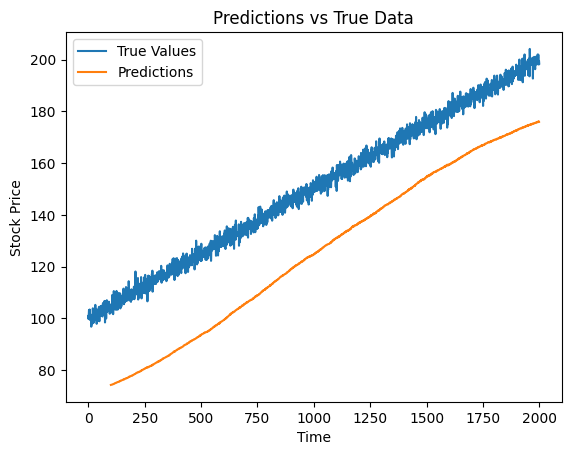

In [14]:
# Make Predictions
predictions = model.predict(X)
predictions = scaler.inverse_transform(predictions)

# Prepare true values for comparison
true_values = scaler.inverse_transform(data.reshape(-1, 1))

# Plot the predcitions vs true values
import matplotlib.pyplot as plt

plt.plot(true_values, label='True Values')
plt.plot(np.arange(time_step, time_step + len(predictions)), predictions, label='Predictions')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.title('Predictions vs True Data')
plt.show()